In [20]:
import pandas as pd
import numpy as np

### Loading the feature functions from CSV and trimming

In [21]:
df = pd.read_csv("features/mm_all.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules
molecules

array(['Mg', 'Na', 'Cu', 'Ca', 'Li', 'Al', 'Ni', 'Mn'], dtype=object)

### Size Modification and adding parameters to Data Frame

In [22]:
# df = df.iloc[:-1, :]
df

,Mol,Pol,Rad,CN,Ion,EN
0,Mg,71.20,160,8,7.646,1.31
1,Na,162.70,157,8,5.139,0.93
2,Cu,46.50,128,12,7.726,1.91
3,Ca,160.80,200,8,6.113,1.00
4,Li,164.11,182,8,5.392,0.98
5,Al,57.80,184,12,5.986,1.61
6,Ni,49.00,163,12,7.640,1.91
7,Mn,68.00,197,8,7.434,1.55


In [23]:

%store -r res
res 

# res = res[:-1]

[17.144355598718082,
 25.027177715806825,
 5.118879491233692,
 22.814559268959076,
 25.719392847659723,
 2.9222363463284893,
 10.553895436793855,
 15.857470042410599]

In [24]:
## always inverse of EN_A
# res = df['EA_A']/np.array(res)

## always inverse of delta EN

## always inverse of pol_A ( anion polarisation)

## remove df['EA_A'] from the dataframe
# df = df.drop(columns=['EA_A'])

res

[17.144355598718082,
 25.027177715806825,
 5.118879491233692,
 22.814559268959076,
 25.719392847659723,
 2.9222363463284893,
 10.553895436793855,
 15.857470042410599]

In [25]:
df = df.iloc[:,1:]


## always inverse of EN_A

# # df['Diff_rad'] = df['RadV_A'] - df['RadV_C']


# df['Sum_ion'] = df['Ion_C'] + df['Ion_A']
# df['Abs_diff_ion'] = abs(df['Ion_C'] - df['Ion_A'])

# df.drop(columns=['Rad','EN'], inplace=True)


# # Adding sqrt values for each column
for col in df.columns:
    # Make sure the column is numeric before applying sqrt
    if pd.api.types.is_numeric_dtype(df[col]):
        df[f'{col}_sqrt'] = np.sqrt(abs(df[col]))
        df[f'{col}_squared'] = np.square(df[col])


# df['cal'] = 1/df['Pol_squared']
# df['cal'] = df['cal']/df['Ion_squared']
# df['cal'] = df['cal']*df['Pol_sqrt']
# df['cal'] = df['cal']/df['EN']


# df.drop(columns=['Pol_squared', 'Ion_squared', 'Rad_squared','EN_squared','Rad_sqrt','Pol_sqrt'], inplace=True)
# df.drop(columns=['Pol_squared', 'Ion_squared', 'Rad_squared','Rad_sqrt','Pol_sqrt','EN_sqrt'], inplace=True)
# df.drop(columns=['Pol_sqrt', 'Rad_squared','EN_squared','Rad_sqrt','Pol_sqrt','CN_squared','Rad'], inplace=True)
# df.drop(columns=['Rad','Rad_squared','Pol','CN_squared','EN','EN_squared','EN_sqrt'], inplace=True)   # good results
# df.drop(columns=['Pol_squared','Ion_squared','Rad','Rad_sqrt','Rad_squared','EN'], inplace=True)   # good results

# df.drop(columns=['Rad','Pol_squared','Ion','Ion_sqrt','Pol_sqrt'], inplace=True)   # good results

# df['sum_ion'] = df['Ion_C'] + df['Ion_A']
# # df['diff_ion'] = df['Ion_C'] - df['Ion_A']

# drop all cols except calc
# df['Pol_cubed'] = df['Pol_squared'] * df['Pol']
# df['Ion_cubed'] = df['Ion_squared'] * df['Ion']
# df['CN_cubed'] = df['CN_squared'] * df['CN']
# df = df[['Ion','Ion_cubed','Pol','Pol_cubed','CN']]
df = df.drop(columns=['EN','EN_squared','EN_sqrt','Ion','Ion_squared','Ion_sqrt'])
# df.drop(columns=)
df.shape

(8, 9)

### making the combinations

In [26]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

In [27]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]

            # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue

            # Select the subset DataFrame
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [28]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

def process_combinations_chunk(args):
    combined_params_df, combined_param_names, param_names, indices_chunk = args
    results = []

    for indices in indices_chunk:
        subset_names = [combined_param_names[i] for i in indices]
        subset = combined_params_df[subset_names]

        # Replace NaN values with 0
        subset = subset.fillna(0)

        # Check if both a parameter and its inverse are in the subset
        invalid = False
        for name in subset_names:
            if name.endswith("^(-1)") and name[:-5] in subset_names:
                invalid = True
                break
            elif name in param_names and f"{name}^(-1)" in subset_names:
                invalid = True
                break

        if not invalid:
            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

def generate_combinations_df_parallel(params_df, param_names):
    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameter indices
    all_combinations = [
        indices for r in range(1, len(combined_param_names) + 1)
        for indices in itertools.combinations(range(len(combined_param_names)), r)
    ]

    # Divide all_combinations into chunks
    num_workers = min(cpu_count(), len(all_combinations))
    chunk_size = max(1, len(all_combinations) // num_workers)
    chunks = [all_combinations[i:i + chunk_size] for i in range(0, len(all_combinations), chunk_size)]

    print(f"Using {num_workers} workers to process {len(all_combinations)} combinations in {len(chunks)} chunks")

    # Prepare arguments for parallel processing
    args = [
        (combined_params_df, combined_param_names, param_names, chunk)
        for chunk in chunks
    ]

    # Use multiprocessing to process combinations in parallel
    with Pool(processes=num_workers) as pool:
        results = pool.map(process_combinations_chunk, args)

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]
    return flattened_results


### Restricted parameters

In [29]:
numeretor = []
denomeretor = []

In [30]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names, restricted_properties=None, restricted_to_inverses=None):
    if restricted_properties is None:
        restricted_properties = []
    if restricted_to_inverses is None:
        restricted_to_inverses = []

    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

     # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})
    
    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):
            subset_names = [combined_param_names[i] for i in subset_indices]

            # Replace NaN values with 0
             # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue
            
            subset = combined_params_df[subset_names]
            subset = subset.fillna(0)

            # Check if both a parameter and its inverse are in the subset
            invalid = False
           
            # Exclude subsets containing restricted inverses
            for restricted in restricted_properties:
                if f"{restricted}^(-1)" in subset_names:
                    invalid = True
                    break

            # Ensure restricted properties only appear as inverses
            for restricted in restricted_to_inverses:
                if restricted in subset_names or (restricted not in param_names and f"{restricted}^(-1)" not in subset_names):
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [31]:

import os
import pandas as pd

takeSaved = False

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.columns)
    all_expressions = generate_combinations_df(df.iloc[:, ], param_names, restricted_properties=numeretor, restricted_to_inverses=denomeretor)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    # expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Calculating expressions...


C:\Users\user\AppData\Local\Temp\ipykernel_13044\3888168962.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


Expressions cached.
(19682, 2)


In [32]:
expressions.head()

,Expression,Value
0,Pol,0 71.20 1 162.70 2 46.50 3 160.8...
1,Rad,0 160 1 157 2 128 3 200 4 182 5...
2,CN,0 8 1 8 2 12 3 8 4 8 5 1...
3,Pol_sqrt,0 8.438009 1 12.755391 2 6.819091 3...
4,Pol_squared,0 5069.4400 1 26471.2900 2 2162.250...


### Addition results to the combinations

In [33]:
values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = res

### Finding Corelation

In [34]:

correlation = values.corr()

correlation.shape

(19683, 19683)

In [50]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:100])
top_vars = results.iloc[1:20].index

res                                                                                                       1.000000
Pol * Rad_sqrt * Rad^(-1) * CN^(-1) * Pol_sqrt^(-1) * CN_squared^(-1)                                     0.966709
Pol_sqrt * Rad_sqrt * Rad^(-1) * CN^(-1) * CN_squared^(-1)                                                0.966709
Rad * Pol_sqrt * Rad_sqrt * CN^(-1) * Rad_squared^(-1) * CN_squared^(-1)                                  0.966709
Rad * Pol_squared * Rad_sqrt * Pol^(-1) * CN^(-1) * Pol_sqrt^(-1) * Rad_squared^(-1) * CN_squared^(-1)    0.966709
                                                                                                            ...   
CN * Pol_sqrt * CN_sqrt^(-1) * CN_squared^(-1)                                                            0.961115
Pol_sqrt * CN_sqrt * CN_squared^(-1)                                                                      0.961115
Pol * Rad * CN^(-1) * Pol_sqrt^(-1) * Rad_squared^(-1) * CN_sqrt^(-1) * CN_squar

### Final Results

In [51]:
# results=correlation['res'].abs().sort_values(ascending=False)
# print(results.iloc[0:20])
# top_vars = results.iloc[1:20].index


In [52]:
param = top_vars[0]

y = values[param]*1e10
x = values['res']

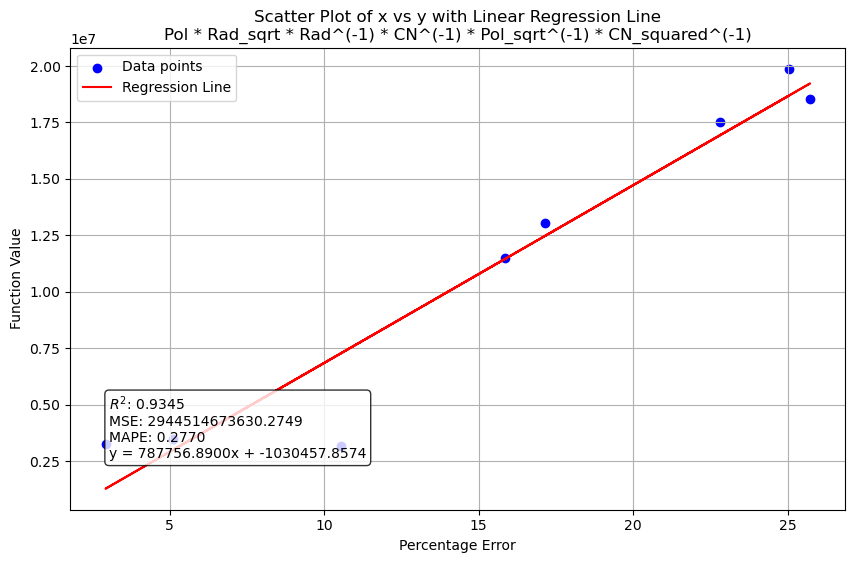

In [53]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Calculate R^2, MSE, and MAPE
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title(f'Scatter Plot of x vs y with Linear Regression Line\n{param}')
plt.xlabel('Percentage Error')
plt.ylabel('Function Value')
plt.grid()
plt.legend()

# Add text box with metrics
textstr = f"$R^2$: {r_squared:.4f}\nMSE: {mse:.4f} \nMAPE: {mape:.4f}\n{equation}"
plt.gca().text(0.05, 0.25, textstr, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.show()


### Results 
1. CN_sqrt * Ion_sqrt * Pol_sqrt^(-1) * Rad_sqrt^(-1) 

2. Rad_sqrt * CN_sqrt * Ion_sqrt * Rad^(-1) * Pol_sqrt^(-1)


After adding alumninum relations changed 

1. Ion * Pol_sqrt * EN_sqrt * EN^(-1) * CN_sqrt^(-1)

After adding Mn

2. EN^(-1) * Pol_sqrt^(-1) * Pol_squared^(-1) * Ion_squared^(-1)  ( 97.1)

Removing Ca 

3. EN * Pol_sqrt^(-1) * Pol_squared^(-1) * CN_sqrt^(-1) * Ion_squared^(-1) * EN_squared^(-1) (98.7)

4. Pol_sqrt * Pol_squared^(-1) * Rad_sqrt^(-1) * CN_sqrt^(-1) * Ion_squared^(-1)  (98.7 less mse)



Final Considered Result 

y = 1/ Pol^3 * 1/ Ion^3 * 1/CN

### Applying ML

In [60]:
# Filter the expressions
filtered_expressions = [(name, values) for name, values in all_expressions if name in top_vars]

In [61]:
import pandas as pd

# Convert your data to a DataFrame
df = pd.DataFrame(filtered_expressions)

# Assuming the column `1` contains lists of numbers
# Expand the column with lists into separate columns
expanded_columns = pd.DataFrame(df[1].tolist())

# Concatenate the expanded columns back with the rest of the DataFrame
df = pd.concat([df.drop(columns=[1]), expanded_columns], axis=1)

df = df.T

df.columns = df.iloc[0]  # Set the first row as column names
df = df[1:]  # Drop the first row since it's now the header

df.shape


res = pd.Series(res)
res.shape

(8,)

In [62]:
X=df
y=res

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale features


In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=11)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)


# Predict
y_pred = model.predict(X_test)

print( y_test, y_pred)


# Compute MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # MAPE in percentage

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Get feature importance (coefficients for linear regression)
features = X.columns  # Feature names
coefficients = model.coef_

# Combine into a dictionary
importance_dict = {feature: coef for feature, coef in zip(features, coefficients)}

# Sort by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)


2     5.118879
6    10.553895
dtype: float64 [3.13815697 2.93503197]
Mean Absolute Percentage Error (MAPE): 55.44%


In [65]:
# Get intercept (β0)
intercept = model.intercept_

# Get coefficients (β1, β2, ..., βn)
coefficients = model.coef_

# Combine features and coefficients into a dictionary
coef_dict = {feature: coef for feature, coef in zip(X.columns, coefficients)}

# Sort coefficients in descending order based on absolute value
sorted_coefs = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Construct the equation
equation = f"y = {intercept:.4f}"
for feature, coef in sorted_coefs:
    equation += f" + ({coef:.4f} * {feature}) \n"

print("Sorted Regression Equation:")
print(equation)


Sorted Regression Equation:
y = 14.4819 + (163125705222835.6562 * Rad * Pol_sqrt * Rad_sqrt * CN^(-1) * Rad_squared^(-1) * CN_sqrt^(-1) * CN_squared^(-1)) 
 + (150412218758580.1562 * Rad * Pol_sqrt * Rad_sqrt * CN^(-1) * Rad_squared^(-1) * CN_squared^(-1)) 
 + (-129318880250226.7500 * Pol_squared * Rad_sqrt * Pol^(-1) * Rad^(-1) * CN^(-1) * Pol_sqrt^(-1) * CN_squared^(-1)) 
 + (-90915462005192.8281 * Pol_squared * Rad_sqrt * Pol^(-1) * Rad^(-1) * CN^(-1) * Pol_sqrt^(-1) * CN_sqrt^(-1) * CN_squared^(-1)) 
 + (-73070188742676.1719 * Pol * Rad_sqrt * Rad^(-1) * CN^(-1) * Pol_sqrt^(-1) * CN_squared^(-1)) 
 + (-54254027143960.2578 * Pol * Rad_sqrt * Rad^(-1) * CN^(-1) * Pol_sqrt^(-1) * CN_sqrt^(-1) * CN_squared^(-1)) 
 + (51305501750139.0703 * Pol_sqrt * Rad_sqrt * Rad^(-1) * CN^(-1) * CN_squared^(-1)) 
 + (42121085461580.7578 * Pol_sqrt * Rad_sqrt * Rad^(-1) * CN^(-1) * CN_sqrt^(-1) * CN_squared^(-1)) 
 + (-26573147040048.8828 * Pol * Rad * Rad_sqrt * CN^(-1) * Pol_sqrt^(-1) * Rad_squared^